# Laboratorio: Implementación de un modelo de Machine Learning

Esta experiencia de laboratorio se trata de implementar un modelo de ML para detección de objetos en imágenes. Para eso usaremos un modelo pre-entrenado llamado [`YOLOV3`](https://pjreddie.com/darknet/yolo/). Este modelo destaca porque funciona realmente rápido y para detectar objetos tiene muy buenos resultados. Para implementar el modelo como un servicio usaremos la popular biblioteca [`fastAPI`](https://fastapi.tiangolo.com/).

## Detección de objetos usando YOLOV3

### Inspeccionando las imágenes

Miremos las imágenes en las que vamos a usar el modelo YOLOV3. Esto nos ayudará a entender cuales son los objetos que comúnmente se usan en problemas de detección. Todas estás imágenes son parte del dataset [`ImageNet`](http://www.image-net.org/index).

In [417]:
from IPython.display import Image, display


Mostrando imagen: apple.jpg


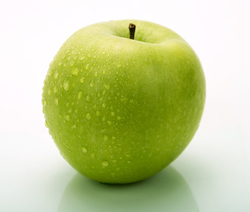


Mostrando imagen: clock.jpg


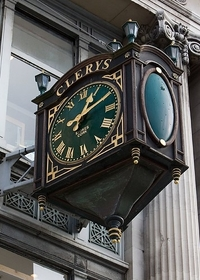


Mostrando imagen: oranges.jpg


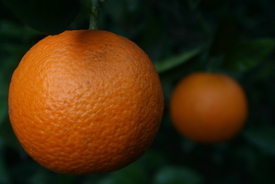


Mostrando imagen: car.jpg


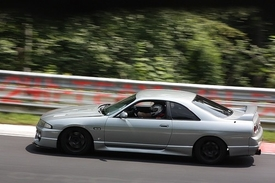

In [418]:
# Algunas imágenes de ejemplo
image_files = [
    'apple.jpg',
    'clock.jpg',
    'oranges.jpg',
    'car.jpg'
]

for image_file in image_files:
    print(f"\nMostrando imagen: {image_file}")
    display(Image(filename=f"images/{image_file}"))

### Resumen del Modelo

Usaremos [`cvlib`](https://www.cvlib.net/), que es una biblioteca simple pero poderosa para hacer detección de objetos combinando dos tecnologías: [`OpenCV`](https://docs.opencv.org/4.5.1/) y [`Tensorflow`](https://www.tensorflow.org/).

En particular usaremos el método [`detect_common_objects`](https://docs.cvlib.net/object_detection/), que toma una imagen en formato de [`numpy array`](https://numpy.org/doc/stable/reference/generated/numpy.array.html) y retorna:

- `bbox`: una lista de listas que incluyen las cajas delimitadoras (bounding boxes) de las detecciones. 

        Ejemplo:
    
    ```python
        [[32, 76, 128, 192], [130, 83, 220, 185]]
    ```
    

- `label`: lista de las etiquetas de los objetos detectados.
    
        Ejemplo:
    ```python
        ['apple', 'apple']
    ```


- `conf`: lista con los scores de confianza de los objetos detectados.
       
       Ejemplo:
        
    ```python
        [0.6187325716018677, 0.42835739254951477]
    ```
    

### Creando la función detect_and_draw_box

Antes de detectar los objetos vamos a crear un directorio donde guardar las imágenes con detecciones:


In [419]:
import os

dir_name = "images_with_boxes"
if not os.path.exists(dir_name):
    os.mkdir(dir_name)

Vamos a crear el método `detect_and_draw_box` que toma como entradas el **nombre de archivo** de un archivo en el sistema, un **modelo**, y un **nivel de confianza**. La función detectará objetos en la imágen y guardará una nueva imágen desplegando las cajas delimitadoras de las detecciones junto al objeto detectado.

¿Por qué le vamos a entregar el modelo como un argumento de entrada? ¿Vamos a poder elegir más de un modelo? Lo que pasa es que el método `detect_common_objects` usa el modelo `yolov3` por defecto.  Sin embargo existe otra opción que es un modelo más pequeño y más rápido de usar: la versión `yolov3-tiny`. Este modelo está diseñado para entornos con restricciones que no pueden correr modelos grande, pero tiene la desventaja que los resultados de detección no son tan precisos como el modelo más grande. Pero de todas formas funciona bastante bien, así que lo usaremos por sobre el `yolov3` normal porque será más mucho más simple de usar.

La salida del modelo es un vector de probabilidades de presencia de distintos objetos en una imágen. El último argumento de entrada a nuestra función (el nivel de confianza) será el umbral que dichas probabilidades deben superar para determinar que el objeto en cuestión si se encuentra en la imágen de entrada. Por defecto `detect_common_objects` usa el valor 0.5 para esto.

In [420]:
import cv2
import cvlib as cv
from cvlib.object_detection import draw_bbox


def detect_and_draw_box(filename, model="yolov3-tiny", confidence=0.5):
    """Detecta objetos en una imágen y crea una nueva imágen de salida con las detecciones y sus cajas delimitadoras.

    Argumentos:
        filename (str): Nombre de archivo de la imagen.
        model (str): Puede ser "yolov3" o "yolov3-tiny". Por defecto será "yolov3-tiny".
        confidence (float, opcional): Nivel de confianza. Por defecto es 0.5.
    """
    
    # Las imágenes están en el directorio images/
    img_filepath = f'images/{filename}'
    
    # Leer la imagen y llevarla a un array de numpy
    img = cv2.imread(img_filepath)
    
    # Hacer la detección de objetos
    bbox, label, conf = cv.detect_common_objects(img, confidence=confidence, model=model)
    
    # Imprimir el nombre de la imagen actual
    print(f"========================\nImagen procesada: {filename}\n")
    
    # Imprimir objetos detectados con su nivel de confianza
    for l, c in zip(label, conf):
        print(f"Objeto detectado: {l}, con un nivel de confianza de {c}\n")
    
    # Crear una nueva imagen que incluya las cajas delimitadoras
    output_image = draw_bbox(img, bbox, label, conf)
    
    # Guardar la imágen en el directorio images_with_boxes
    cv2.imwrite(f'images_with_boxes/{filename}', output_image)
    
    # Desplegar la imágen con cajas delimitadoras
    display(Image(f'images_with_boxes/{filename}'))

Probemos sobre las imágenes de ejemplo:

Imagen procesada: apple.jpg

Objeto detectado: apple, con un nivel de confianza de 0.5717206597328186



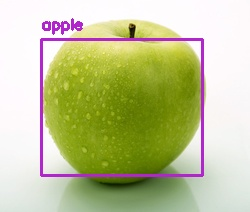

Imagen procesada: clock.jpg

Objeto detectado: clock, con un nivel de confianza de 0.9683184623718262



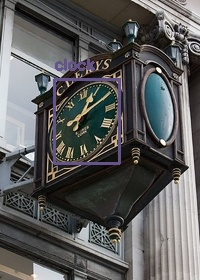

Imagen procesada: oranges.jpg

Objeto detectado: orange, con un nivel de confianza de 0.6185588836669922

Objeto detectado: orange, con un nivel de confianza de 0.5561690330505371



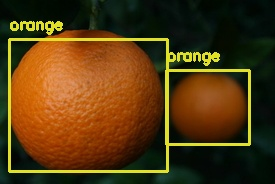

Imagen procesada: car.jpg

Objeto detectado: car, con un nivel de confianza de 0.6325406432151794



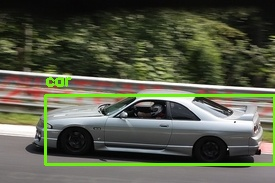

In [421]:
for image_file in image_files:
    detect_and_draw_box(image_file)

## Cambiando el nivel de confianza

Parece que la detección de objetos está saliendo bien. Intentemos con imágenes más complicadas.

Imagen procesada: fruits.jpg

Objeto detectado: apple, con un nivel de confianza de 0.5818482041358948

Objeto detectado: orange, con un nivel de confianza de 0.5346484184265137

Objeto detectado: orange, con un nivel de confianza de 0.515099287033081



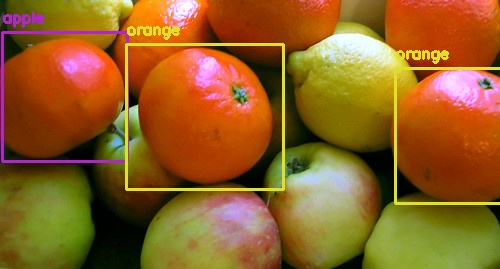

In [422]:
detect_and_draw_box("fruits.jpg")

El **modelo falló y no detectó** varias frutas y **clasificó mal** una naranja como una manzana. Esto puede resultae extraño dado que antes si había logrado detectar una manzana, por lo que se podría pensar que el modelo entiende bien cómo son las manzanas.

Una posibilidad es que el modelo **detectó** efectivamente las otras frutas pero con un nivel de confianza menor a 0.5. Veamos si es una hipótesis válida:

Imagen procesada: fruits.jpg

Objeto detectado: apple, con un nivel de confianza de 0.5818482041358948

Objeto detectado: orange, con un nivel de confianza de 0.5346484184265137

Objeto detectado: orange, con un nivel de confianza de 0.515099287033081

Objeto detectado: apple, con un nivel de confianza de 0.34759870171546936

Objeto detectado: orange, con un nivel de confianza de 0.32876086235046387

Objeto detectado: apple, con un nivel de confianza de 0.31244686245918274

Objeto detectado: orange, con un nivel de confianza de 0.27986079454421997

Objeto detectado: orange, con un nivel de confianza de 0.2749977707862854

Objeto detectado: apple, con un nivel de confianza de 0.2744504511356354

Objeto detectado: orange, con un nivel de confianza de 0.21419058740139008



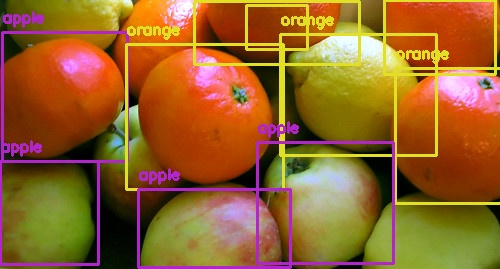

In [423]:
detect_and_draw_box("fruits.jpg", confidence=0.2)

Bajando el nivel de confianza el modelo es capaz de detectar la mayoría de las frutas. Pero para lograr eso tuvimos que establecer el nivel de confianza en un valor bien bajo. En general debemos tener cuidado al aumentar o disminuir este tipo de parámetros, ya que cambiarlos puede llevar a conseguir resultados no deseados.

Y para este ejemplo en concreto, que una naranja fue clasificada mal como una manza es un recordatorio que estos modelos no son perfectos y debemos considerar eso cuando queramos usarlos en un producto de datos.

## Implementando el modelo usando fastAPI


### Poniendo nuestro modelo de detección de objetos en un servidor

Vamos a mencionar algunos conceptos esenciales y como los vamos a llevar a `fastAPI`. Vamos a crear un directorio para guardar las imágenes que se vayan subiendo al servidor:

In [424]:
dir_name = "images_uploaded"
if not os.path.exists(dir_name):
    os.mkdir(dir_name)

### Conceptos importantes

#### Modelo Cliente-Servidor

Cuando hablamos de **implementar**, lo que usualmente se quiere decir es que vamos a poner todo el software necesario para realizar predicciones en un `server` (servidor). De esta forma un `client` (cliente) puede interactuar con el modelo enviando `requests` (solicitudes) al servidor. 

Lo importante entonces es que el modelo de Machine Learning vive en un servidor esperando por clientes que le envíen solicitudes de predicciones. El cliente tiene que entregarle toda la información necesaria que el modelo necesita para poder hacer una predicción. Tengamos en mente que es común acumular más de una predicción en una misma solicitud. El servidor usará la información que le proporcionen para devolver predicciones al cliente, el cual puede usarlas a su antojo.

Empecemos creando una instancia de la clase `FastAPI`:

```python
app = FastAPI()
```

El siguiente paso es usar esa instancia para crear endpoints que manejarán la lógica para hacer predicciones. Una vez que todo el código está listo para correr el servidor solo hay que usar el siguiente comando:

```python
uvicorn.run(app)
```

La API está construida usando código de fastAPI pero "servirla" se hace mediante [`uvicorn`](https://www.uvicorn.org/), que es una Asynchronous Server Gateway Interface (ASGI) de muy rápida implementación. Ambas tecnologías están super conectadas pero no necesitamos entender los detalles técnicos. Sólo hay que tener en cuenta que es uvicorn el que se encarga de servir el código.

#### Endpoints

Podemos hospedar varios modelos de Machine Learning en el mismo servidor. Para esto podemos asignarles un `endpoint` diferente a cada modelo para que sepamos siempre cuál de los modelos estamos usando. Un endpoint se representa como un patrón en la `URL`. Por ejemplo si tenemos un sitio que se llama `misupermodelo.com` también podríamos tener tres diferentes modelos en los siguientes endpoints:

- `misupermodelo.com/contador-autos/`
- `misupermodelo.com/contador-naranjas/`
- `misupermodelo.com/contador-guitarras/`

Cada modelo llevaría a cabo la tarea que el patrón de la URL indica.

En fastAPI podemos definir un endpoint creando una función que se encargue de manejar la lógica que corresponde. Además se incluye un [decorador](https://www.python.org/dev/peps/pep-0318/) con una función que contiene la información de que método HTTP está permitido y cuál es el patrón de la URL que se usará para el endpoint en cuestión.

El siguiente ejemplo muestra como generar una solicitud HTTP GET en el endpoint endpoint "/mi-endpoint":

```python
@app.get("/mi-endpoint")
def handle_endpoint():
    ...
    ...
```


#### Solicitudes HTTP

El cliente y el servidor se comunican entre sí a través de un protocolo llamado `HTTP`. El concepto clave es que la comunicación entre cliente y servidor usa ciertos verbos que denotan acciones. Dos verbos comunes son:

- `GET` -> Obtiene información del servidor.
- `POST` -> Entrega información al servidor, la cual se usa para responder.

Si el cliente hace un `GET request` a un endpoint el servidor entregará información del endpoint sin necesidad de que le proporcionemos información adicional. En el caso de un `POST request` le estamos diciendo de manera explícita al servidor que le entregaremos información para que la procese de alguna forma.

Para interactuar con modelos de Machine Learning que estén viviendo en endpoints usualmente hacemos un `POST request` ya que siempre necesitaremos entregarle información para que realice predicciones.

Así luce un POST request:

```python
@app.post("/mi-otro-endpoint")
def handle_other_endpoint(param1: int, param2: str):
    ...
    ...

```

Para POST requests, la función debe contener parámetros. En contraste con un GET, las solicitudes POST esperan que el cliente les entregue alguna información. En este ejemplo proveerá un entero y un string.


### ¿Por qué fastAPI?

Con fastAPI podemos crear servidores web par hospedar modelos de manera muy sencilla. Adicionalmente la plataforma es extremadamente rápida.

In [425]:
import io
import uvicorn
import numpy as np
import nest_asyncio
from enum import Enum
from fastapi import FastAPI, UploadFile, File, HTTPException
from fastapi.responses import StreamingResponse

In [426]:
# Asignamos una instancia de la clase FastAPI a la variable "app".
# Interacturaremos con la API usando este elemento.
app = FastAPI(title='Implementando un modelo de Machine Learning usando FastAPI')

# Enlistamos los modelos disponibles usando Enum. Útil cuando tenemos opciones predefinidas.
class Model(str, Enum):
    yolov3tiny = "yolov3-tiny"
    yolov3 = "yolov3"


# Usando @app.get("/") definimos un método GET para el endpoint / (que sería como el "home").
@app.get("/")
def home():
    return "¡Felicitaciones! Tu API está funcionando según lo esperado. Anda ahora a http://localhost:8000/docs."

# Este endpoint maneja la lógica necesaria para detectar objetos.
# Requiere como entrada el modelo deseado y la imagen.
# En este endpoint le agregamos la variable conf indicando que es un float.
@app.post("/predict") 
def prediction(model: Model, conf: float, file: UploadFile = File(...)):

    # 1. Validad el archivo de entrada
    filename = file.filename
    fileExtension = filename.split(".")[-1] in ("jpg", "jpeg", "png")
    if not fileExtension:
        raise HTTPException(status_code=415, detail="Tipo de archivo no soportado.")
    
    # 2. Transformar la imagen cruda a una imagen CV2
    
    # Leer la imagen como un stream de bytes
    image_stream = io.BytesIO(file.file.read())
    
    # Empezar el stream desde el principio (posicion cero)
    image_stream.seek(0)
    
    # Escribir el stream en un numpy array
    file_bytes = np.asarray(bytearray(image_stream.read()), dtype=np.uint8)
    
    # Decodificar el numpy array como una imagen
    image = cv2.imdecode(file_bytes, cv2.IMREAD_COLOR)
    
    
    # 3. Correr el modelo de detección de objetos
    
    # Correr la detección de objetos
    bbox, label, conf = cv.detect_common_objects(image,
                                                 confidence=conf, model=model)
   
    # Crear una imagen que contenga las cajas delimitadoras y etiquetas
    output_image = draw_bbox(image, bbox, label, conf)
    
    # Guardarla en un directorio del server
    cv2.imwrite(f'images_uploaded/{filename}', output_image)
    
    
    # 4. Transmitir la respuesta de vuelta al cliente
    
    # Abrir la imagen para leerla en formato binario
    file_image = open(f'images_uploaded/{filename}', mode="rb")
    
    # Retornar la imagen como un stream usando un formato específico
    return StreamingResponse(file_image, media_type="image/jpeg")

In [427]:
# Debo agregar cómo poder seleccionar una fruta en específico y luego que esa 
# selección pase hacia abajo.


In [428]:

from collections import Counter
import pandas as pd

# Enlistamos los modelos disponibles usando Enum. Útil cuando tenemos opciones predefinidas.
class objeto(str, Enum):
    orange = "orange"
    

## Pregunta 2.3

In [429]:

@app.post("/countObjects") 
def countObjects(model: Model, conf: float, file: UploadFile = File(...)):

    # 1. Validad el archivo de entrada
    filename = file.filename
    fileExtension = filename.split(".")[-1] in ("jpg", "jpeg", "png")
    if not fileExtension:
        raise HTTPException(status_code=415, detail="Tipo de archivo no soportado.")
    
    # 2. Transformar la imagen cruda a una imagen CV2
    
    # Leer la imagen como un stream de bytes
    image_stream = io.BytesIO(file.file.read())
    
    # Empezar el stream desde el principio (posicion cero)
    image_stream.seek(0)
    
    # Escribir el stream en un numpy array
    file_bytes = np.asarray(bytearray(image_stream.read()), dtype=np.uint8)
    
    # Decodificar el numpy array como una imagen
    image = cv2.imdecode(file_bytes, cv2.IMREAD_COLOR)
    
    # 3. Correr el modelo de detección de objetos
    
    # Correr la detección de objetos
    bbox, label, conf = cv.detect_common_objects(image,
                                                 confidence=conf, model=model)
   
    # Crear una imagen que contenga las cajas delimitadoras y etiquetas
    output_image = draw_bbox(image, bbox, label, conf)
    
    # Guardarla en un directorio del server
    cv2.imwrite(f'images_uploaded/{filename}', output_image)
    
    # Retornar el label y la ocurrencia de c/u
    return Counter(label)

¡Corriendo la celda que viene echaremos a andar el servidor!

Esto causará que el notebook se bloquee (no podremos correr más celdas) hasta que interrumpamos de forma manual el kernel. Podemos hacer eso haciendo click en la pestaña `Kernel` y luego `Interrupt`.

In [430]:
# Esto deja correr al servidor en un ambiente interactivo como un Jupyter notebook
nest_asyncio.apply()

# Donde se hospedará el servidor
host = "127.0.0.1"

# ¡Iniciemos el servidor!    
uvicorn.run(app, host=host, port=8000)

INFO:     Started server process [1181]
INFO:     Waiting for application startup.
INFO:     Application startup complete.
INFO:     Uvicorn running on http://127.0.0.1:8000 (Press CTRL+C to quit)


INFO:     127.0.0.1:35806 - "POST /predict?model=yolov3-tiny&conf=0.2 HTTP/1.1" 200 OK
INFO:     127.0.0.1:35808 - "POST /predict?model=yolov3-tiny&conf=0.2 HTTP/1.1" 200 OK
INFO:     127.0.0.1:35810 - "POST /predict?model=yolov3-tiny&conf=0.2 HTTP/1.1" 200 OK
INFO:     127.0.0.1:35812 - "POST /predict?model=yolov3-tiny&conf=0.2 HTTP/1.1" 200 OK
INFO:     127.0.0.1:35814 - "POST /countObjects?model=yolov3-tiny&conf=0.2 HTTP/1.1" 200 OK
INFO:     127.0.0.1:35816 - "POST /countObjects?model=yolov3-tiny&conf=0.2 HTTP/1.1" 200 OK
INFO:     127.0.0.1:35818 - "POST /countObjects?model=yolov3-tiny&conf=0.2 HTTP/1.1" 200 OK
INFO:     127.0.0.1:35820 - "POST /countObjects?model=yolov3-tiny&conf=0.2 HTTP/1.1" 200 OK
INFO:     127.0.0.1:35822 - "POST /countObjects?model=yolov3-tiny&conf=0.2 HTTP/1.1" 200 OK
INFO:     127.0.0.1:35824 - "POST /countObjects?model=yolov3-tiny&conf=0.2 HTTP/1.1" 200 OK
INFO:     127.0.0.1:35826 - "POST /countObjects?model=yolov3-tiny&conf=0.2 HTTP/1.1" 200 OK
INFO:   

INFO:     Shutting down
INFO:     Waiting for application shutdown.
INFO:     Application shutdown complete.
INFO:     Finished server process [1181]


¡El servidor está corriendo! Vamos a [http://localhost:8000/](http://localhost:8000/) para verlo en acción.

**Probemos enviando una imagen** y veamos como nuestra API es capaz de detectar objetos en ella y retornar una nueva imagen conteniendo las cajas delimitadoras y las etiquetas de los objetos detectados. **Podemos hacer eso visitando [http://localhost:8000/docs](http://localhost:8000/docs) para abrir un cliente que viene dentro de fastAPI.** 


Si hacemos click en el endpoint `/predict` se verán más opciones. Para probar el servidor hay que usar el botón **Try it out**.

Podemos elegir un modelo usando el campo **model** y un archivo **file** que debe ser la imagen en la que queremos que el servidor detecte objetos.

**Para enviar una imagen** desde nuestro computador debemos hacer click en el botón **Choose File**, luego en el botón azul **Execute** para enviar una solicitud HTTP al servidor. Luego de hacer eso debemos **bajar con el mouse y veremos la respuesta**.

**¡Probemos con imágenes distintas!** Recordemos que como el modelo está usando el nivel de confianza por defecto de 0.5 puede que no siempre encuentr objetos.


## Consumiendo el modelo desde otro cliente

Es genial que fastAPI permita interactuar con la API por medio del cliente que tiene incorporado. Pero debemos aprender como usar la API desde cualquier tipo de código, no necesariamente con una interfaz.

Para eso iremos al siguiente notebook donde implementaremos un cliente básico en Python. Para esto **debemos dejar corriendo el servidor (no paremos el kernal ni cerremos esta ventana)** y abramos el notebook `client.ipynb` notebook.